In [1]:
import pandas as pd
import os
import torch
import torch.nn as nn
import torchvision
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as transforms
from skimage import io
from tqdm import tqdm
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import torch.nn.functional as F
import numpy as np
import random
from PIL import Image
import random

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
import zipfile

zip_path = "/content/drive/MyDrive/MNIST_Bounding_Box/MNIST_Converted_Testing.zip"
output_dir = "/content/MNIST"

with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(output_dir)

zip_path = "/content/drive/MyDrive/MNIST_Bounding_Box/MNIST_Converted_Training.zip"
output_dir = "/content/MNIST"

with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(output_dir)

In [4]:
df1 = pd.read_csv("/content/drive/MyDrive/MNIST_Bounding_Box/training_data.csv", header = None)
root_dir1 = "/content/MNIST/MNIST_Converted_Training"
df2 = pd.read_csv("/content/drive/MyDrive/MNIST_Bounding_Box/test_data.csv", header = None)
root_dir2 = "/content/MNIST/MNIST_Converted_Testing"
print(df1, df2)

                                 0  1   2   3
0          converted_training1.png  5  20   0
1          converted_training2.png  0  33  13
2          converted_training3.png  4  14   7
3          converted_training4.png  1  33  38
4          converted_training5.png  9  68   3
...                            ... ..  ..  ..
59995  converted_training59996.png  8  39   4
59996  converted_training59997.png  3  52  28
59997  converted_training59998.png  5   5  26
59998  converted_training59999.png  6  45  40
59999  converted_training60000.png  8  34  57

[60000 rows x 4 columns]                                0  1   2   3
0         converted_testing1.png  7  59  44
1         converted_testing2.png  2  48  11
2         converted_testing3.png  1  65  30
3         converted_testing4.png  0  10   3
4         converted_testing5.png  4  38  60
...                          ... ..  ..  ..
9995   converted_testing9996.png  2  11  38
9996   converted_testing9997.png  3  63  27
9997   converted_testing99

In [5]:
class MNIST_Dataset(Dataset):
    def __init__(self, dataframe, root_dir):
        self.annotations = dataframe
        self.root_dir = root_dir

    def __len__(self):
        return len(self.annotations)

    def __getitem__(self,index):
        img_path = os.path.join(self.root_dir, self.annotations.iloc[index, 0])
        image = io.imread(img_path)
        image = torch.tensor(image).double().unsqueeze(0)

        y_label=torch.tensor(int(self.annotations.iloc[index, 1]))

        corners = torch.tensor(self.annotations.iloc[index, 2 : ].values.astype(float)).double() / 100

        return (image, y_label, corners)

In [6]:
batch_size = 100
train_dataset = MNIST_Dataset(df1, root_dir1)
test_dataset = MNIST_Dataset(df2, root_dir2)

device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [7]:
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

In [8]:
class CNN1(nn.Module):
    def __init__(self):
        super(CNN1, self).__init__()
        self.cnn = nn.Sequential(
            nn.Conv2d(1,32, kernel_size = 4, stride = 2, padding = 1),
            nn.Conv2d(32, 64, kernel_size = 3, stride = 1, padding = 1),
            nn.MaxPool2d(kernel_size = 2, stride = 2, padding = 0),
            nn.Conv2d(64, 128, kernel_size = 3, stride = 1, padding = 1),
            nn.MaxPool2d(kernel_size = 2, stride = 2, padding = 0),
            nn.Conv2d(128, 128, kernel_size = 3, stride = 1, padding = 1),
            nn.MaxPool2d(kernel_size = 2, stride = 2, padding = 0),
            nn.Conv2d(128, 256, kernel_size = 3, stride = 1, padding = 1),
            nn.MaxPool2d(kernel_size = 2, stride = 2, padding = 0))

        # self.fc1 = nn.Linear(760384, 16928)
        self.fc = nn.Sequential(nn.Flatten(),
                                nn.Linear(2304, 500),
                                nn.Linear(500, 2),
                                 nn.Sigmoid())

    def forward(self,data):
        x = self.cnn(data)
        bb = self.fc(x)
        return bb

model1 = CNN1().double().to(device)
model1

CNN1(
  (cnn): Sequential(
    (0): Conv2d(1, 32, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (1): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (7): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (fc): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=2304, out_features=500, bias=True)
    (2): Linear(in_features=500, out_features=2, bias=True)
    (3): Sigmoid()
  )
)

In [9]:
class CNN2(nn.Module):
    def __init__(self):
        super(CNN2, self).__init__()
        self.cnn = nn.Sequential(
            nn.Conv2d(1,32, kernel_size = 4, stride = 2, padding = 1),
            nn.Conv2d(32, 64, kernel_size = 3, stride = 1, padding = 1),
            nn.MaxPool2d(kernel_size = 2, stride = 2, padding = 0),
            nn.Conv2d(64, 128, kernel_size = 3, stride = 1, padding = 1),
            nn.ReLU(),
            nn.Conv2d(128, 128, kernel_size = 3, stride = 1, padding = 1),
            nn.MaxPool2d(kernel_size = 2, stride = 2, padding = 0),
            nn.Conv2d(128, 256, kernel_size = 3, stride = 1, padding = 1),
            nn.MaxPool2d(kernel_size = 2, stride = 2, padding = 0))

        self.classifier = nn.Sequential(
                                  nn.Conv2d(256, 512, kernel_size = 3, stride = 1, padding = 1),
                                  nn.MaxPool2d(kernel_size = 2, stride = 2, padding = 0),
                                  nn.Flatten(),
                                  nn.ReLU(),
                                  nn.Linear(4608, 10),
                                 nn.Sigmoid())

    def forward(self,data):
        x = self.cnn(data)
        cls = self.classifier(x)
        return cls

model2 = CNN2().double().to(device)
model2

CNN2(
  (cnn): Sequential(
    (0): Conv2d(1, 32, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (1): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): ReLU()
    (5): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (7): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (classifier): Sequential(
    (0): Conv2d(256, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (2): Flatten(start_dim=1, end_dim=-1)
    (3): ReLU()
    (4): Linear(in_features=4608, out_features=10, bias=True)
    (5): Sigm

In [10]:
total_step = len(train_loader)
acc_lst = []
loss_lst = []
classes=[0,1]
num_epochs = 4
loss_criteria_cls = nn.CrossEntropyLoss()
loss_criteria_bb = nn.MSELoss()
optimizer1 = torch.optim.Adam(model1.parameters(), lr = 0.00006)
optimizer2 = torch.optim.Adam(model2.parameters(), lr = 0.00006)
for epoch in range(num_epochs):
    for i, (images, labels, corners) in enumerate(tqdm(train_loader)):
        images = images.to(device)
        labels = F.one_hot(labels, num_classes=10)
        labels = labels.type(torch.FloatTensor)
        labels = labels.to(device)

        corners = corners.to(device)

        bb = model1(images)
        cls = model2(images)

        loss_cls = loss_criteria_cls(cls, labels)
        loss_lst.append(loss_cls.item())

        optimizer2.zero_grad()
        loss_cls.backward()
        optimizer2.step()

        loss_bb = loss_criteria_bb(bb, corners)
        loss_lst.append(loss_bb.item())

        optimizer1.zero_grad()
        loss_bb.double().backward()
        optimizer1.step()

        labels =  torch.argmax(labels, dim=1)
        total = labels.size(0)
        _, predicted = torch.max(cls.data, 1)
        correct = (predicted == labels).sum().item()
        acc_lst.append((correct / total) * 100)
        if i%50 == 0:
            print('Epoch [{}/{}], Loss_Cls: {:.8f}, Loss_bb: {:.8f}, Accuracy:{:.2f}%'.format(epoch + 1, num_epochs, loss_cls.item(), loss_bb.item(), (correct / total) * 100))

    print('Epoch [{}/{}], Loss_Cls: {:.8f}, Loss_bb: {:.8f}, Accuracy:{:.2f}%'.format(epoch + 1, num_epochs, loss_lst[-2], loss_lst[-1], acc_lst[-1]))

  0%|          | 1/600 [00:09<1:35:21,  9.55s/it]

Epoch [1/4], Loss_Cls: 2.29789908, Loss_bb: 0.10324021, Accuracy:11.00%


  8%|▊         | 51/600 [01:18<12:43,  1.39s/it]

Epoch [1/4], Loss_Cls: 2.24587582, Loss_bb: 0.00207595, Accuracy:27.00%


 17%|█▋        | 101/600 [02:29<11:43,  1.41s/it]

Epoch [1/4], Loss_Cls: 1.99478269, Loss_bb: 0.00107875, Accuracy:45.00%


 25%|██▌       | 151/600 [03:39<10:33,  1.41s/it]

Epoch [1/4], Loss_Cls: 1.83844365, Loss_bb: 0.00078047, Accuracy:52.00%


 34%|███▎      | 201/600 [04:50<09:25,  1.42s/it]

Epoch [1/4], Loss_Cls: 1.76090745, Loss_bb: 0.00067323, Accuracy:69.00%


 42%|████▏     | 251/600 [06:00<08:11,  1.41s/it]

Epoch [1/4], Loss_Cls: 1.73858699, Loss_bb: 0.00061780, Accuracy:69.00%


 50%|█████     | 301/600 [07:11<07:01,  1.41s/it]

Epoch [1/4], Loss_Cls: 1.68593951, Loss_bb: 0.00056291, Accuracy:73.00%


 58%|█████▊    | 351/600 [08:21<05:50,  1.41s/it]

Epoch [1/4], Loss_Cls: 1.59602904, Loss_bb: 0.00040555, Accuracy:81.00%


 67%|██████▋   | 401/600 [09:32<04:40,  1.41s/it]

Epoch [1/4], Loss_Cls: 1.57791935, Loss_bb: 0.00043748, Accuracy:91.00%


 75%|███████▌  | 451/600 [10:42<03:29,  1.40s/it]

Epoch [1/4], Loss_Cls: 1.58201635, Loss_bb: 0.00053774, Accuracy:89.00%


 84%|████████▎ | 501/600 [11:52<02:18,  1.40s/it]

Epoch [1/4], Loss_Cls: 1.57536355, Loss_bb: 0.00032414, Accuracy:87.00%


 92%|█████████▏| 551/600 [13:03<01:08,  1.41s/it]

Epoch [1/4], Loss_Cls: 1.53743868, Loss_bb: 0.00028292, Accuracy:95.00%


100%|██████████| 600/600 [14:12<00:00,  1.42s/it]


Epoch [1/4], Loss_Cls: 1.53113855, Loss_bb: 0.00032433, Accuracy:90.00%


  0%|          | 1/600 [00:01<14:17,  1.43s/it]

Epoch [2/4], Loss_Cls: 1.53440319, Loss_bb: 0.00040342, Accuracy:92.00%


  8%|▊         | 51/600 [01:11<12:58,  1.42s/it]

Epoch [2/4], Loss_Cls: 1.54220243, Loss_bb: 0.00031111, Accuracy:94.00%


 17%|█▋        | 101/600 [02:22<11:46,  1.42s/it]

Epoch [2/4], Loss_Cls: 1.52767820, Loss_bb: 0.00025395, Accuracy:94.00%


 25%|██▌       | 151/600 [03:32<10:32,  1.41s/it]

Epoch [2/4], Loss_Cls: 1.58776024, Loss_bb: 0.00022608, Accuracy:88.00%


 34%|███▎      | 201/600 [04:43<09:21,  1.41s/it]

Epoch [2/4], Loss_Cls: 1.56632279, Loss_bb: 0.00021998, Accuracy:89.00%


 42%|████▏     | 251/600 [05:53<08:13,  1.42s/it]

Epoch [2/4], Loss_Cls: 1.49468177, Loss_bb: 0.00017295, Accuracy:96.00%


 50%|█████     | 301/600 [07:04<07:00,  1.41s/it]

Epoch [2/4], Loss_Cls: 1.52505053, Loss_bb: 0.00020375, Accuracy:92.00%


 58%|█████▊    | 351/600 [08:14<05:49,  1.40s/it]

Epoch [2/4], Loss_Cls: 1.47683637, Loss_bb: 0.00019208, Accuracy:100.00%


 67%|██████▋   | 401/600 [09:24<04:38,  1.40s/it]

Epoch [2/4], Loss_Cls: 1.52138882, Loss_bb: 0.00018372, Accuracy:95.00%


 75%|███████▌  | 451/600 [10:35<03:28,  1.40s/it]

Epoch [2/4], Loss_Cls: 1.52592047, Loss_bb: 0.00021198, Accuracy:95.00%


 84%|████████▎ | 501/600 [11:45<02:18,  1.40s/it]

Epoch [2/4], Loss_Cls: 1.52325997, Loss_bb: 0.00017047, Accuracy:91.00%


 92%|█████████▏| 551/600 [12:56<01:08,  1.40s/it]

Epoch [2/4], Loss_Cls: 1.53625829, Loss_bb: 0.00015678, Accuracy:92.00%


100%|██████████| 600/600 [14:05<00:00,  1.41s/it]


Epoch [2/4], Loss_Cls: 1.53140059, Loss_bb: 0.00019331, Accuracy:94.00%


  0%|          | 1/600 [00:01<14:22,  1.44s/it]

Epoch [3/4], Loss_Cls: 1.52432244, Loss_bb: 0.00017769, Accuracy:95.00%


  8%|▊         | 51/600 [01:11<12:57,  1.42s/it]

Epoch [3/4], Loss_Cls: 1.48125648, Loss_bb: 0.00018004, Accuracy:96.00%


 17%|█▋        | 101/600 [02:22<11:49,  1.42s/it]

Epoch [3/4], Loss_Cls: 1.48291989, Loss_bb: 0.00015608, Accuracy:97.00%


 25%|██▌       | 151/600 [03:32<10:33,  1.41s/it]

Epoch [3/4], Loss_Cls: 1.52795192, Loss_bb: 0.00014153, Accuracy:93.00%


 34%|███▎      | 201/600 [04:42<09:21,  1.41s/it]

Epoch [3/4], Loss_Cls: 1.47090535, Loss_bb: 0.00013685, Accuracy:99.00%


 42%|████▏     | 251/600 [05:53<08:09,  1.40s/it]

Epoch [3/4], Loss_Cls: 1.50741499, Loss_bb: 0.00016023, Accuracy:95.00%


 50%|█████     | 301/600 [07:03<07:00,  1.41s/it]

Epoch [3/4], Loss_Cls: 1.50622360, Loss_bb: 0.00013991, Accuracy:96.00%


 58%|█████▊    | 351/600 [08:13<05:48,  1.40s/it]

Epoch [3/4], Loss_Cls: 1.49400804, Loss_bb: 0.00015203, Accuracy:97.00%


 67%|██████▋   | 401/600 [09:24<04:38,  1.40s/it]

Epoch [3/4], Loss_Cls: 1.50503863, Loss_bb: 0.00014866, Accuracy:95.00%


 75%|███████▌  | 451/600 [10:34<03:28,  1.40s/it]

Epoch [3/4], Loss_Cls: 1.51162384, Loss_bb: 0.00013560, Accuracy:94.00%


 84%|████████▎ | 501/600 [11:44<02:19,  1.41s/it]

Epoch [3/4], Loss_Cls: 1.50390873, Loss_bb: 0.00015038, Accuracy:96.00%


 92%|█████████▏| 551/600 [12:55<01:09,  1.42s/it]

Epoch [3/4], Loss_Cls: 1.49152540, Loss_bb: 0.00012826, Accuracy:98.00%


100%|██████████| 600/600 [14:04<00:00,  1.41s/it]


Epoch [3/4], Loss_Cls: 1.49666064, Loss_bb: 0.00012428, Accuracy:97.00%


  0%|          | 1/600 [00:01<14:00,  1.40s/it]

Epoch [4/4], Loss_Cls: 1.50037285, Loss_bb: 0.00010039, Accuracy:96.00%


  8%|▊         | 51/600 [01:11<12:55,  1.41s/it]

Epoch [4/4], Loss_Cls: 1.48766363, Loss_bb: 0.00009118, Accuracy:97.00%


 17%|█▋        | 101/600 [02:22<11:43,  1.41s/it]

Epoch [4/4], Loss_Cls: 1.48663673, Loss_bb: 0.00010356, Accuracy:96.00%


 25%|██▌       | 151/600 [03:32<10:31,  1.41s/it]

Epoch [4/4], Loss_Cls: 1.51748453, Loss_bb: 0.00010775, Accuracy:96.00%


 34%|███▎      | 201/600 [04:42<09:20,  1.40s/it]

Epoch [4/4], Loss_Cls: 1.48689949, Loss_bb: 0.00014270, Accuracy:97.00%


 42%|████▏     | 251/600 [05:53<08:09,  1.40s/it]

Epoch [4/4], Loss_Cls: 1.50907600, Loss_bb: 0.00008843, Accuracy:96.00%


 50%|█████     | 301/600 [07:03<06:59,  1.40s/it]

Epoch [4/4], Loss_Cls: 1.52256213, Loss_bb: 0.00011860, Accuracy:93.00%


 58%|█████▊    | 351/600 [08:14<05:48,  1.40s/it]

Epoch [4/4], Loss_Cls: 1.49217674, Loss_bb: 0.00012058, Accuracy:97.00%


 67%|██████▋   | 401/600 [09:24<04:40,  1.41s/it]

Epoch [4/4], Loss_Cls: 1.49217152, Loss_bb: 0.00011025, Accuracy:96.00%


 75%|███████▌  | 451/600 [10:34<03:30,  1.41s/it]

Epoch [4/4], Loss_Cls: 1.47950971, Loss_bb: 0.00009806, Accuracy:99.00%


 84%|████████▎ | 501/600 [11:44<02:19,  1.41s/it]

Epoch [4/4], Loss_Cls: 1.49139611, Loss_bb: 0.00009799, Accuracy:98.00%


 92%|█████████▏| 551/600 [12:55<01:09,  1.41s/it]

Epoch [4/4], Loss_Cls: 1.50242598, Loss_bb: 0.00010848, Accuracy:98.00%


100%|██████████| 600/600 [14:04<00:00,  1.41s/it]

Epoch [4/4], Loss_Cls: 1.47072888, Loss_bb: 0.00011434, Accuracy:100.00%


torch.Size([1, 100, 100])
torch.Size([1, 100, 100])
torch.Size([1, 100, 100])
torch.Size([1, 100, 100])
torch.Size([1, 100, 100])
torch.Size([1, 100, 100])
torch.Size([1, 100, 100])
torch.Size([1, 100, 100])
torch.Size([1, 100, 100])
torch.Size([1, 100, 100])
torch.Size([1, 100, 100])
torch.Size([1, 100, 100])
torch.Size([1, 100, 100])
torch.Size([1, 100, 100])
torch.Size([1, 100, 100])
torch.Size([1, 100, 100])


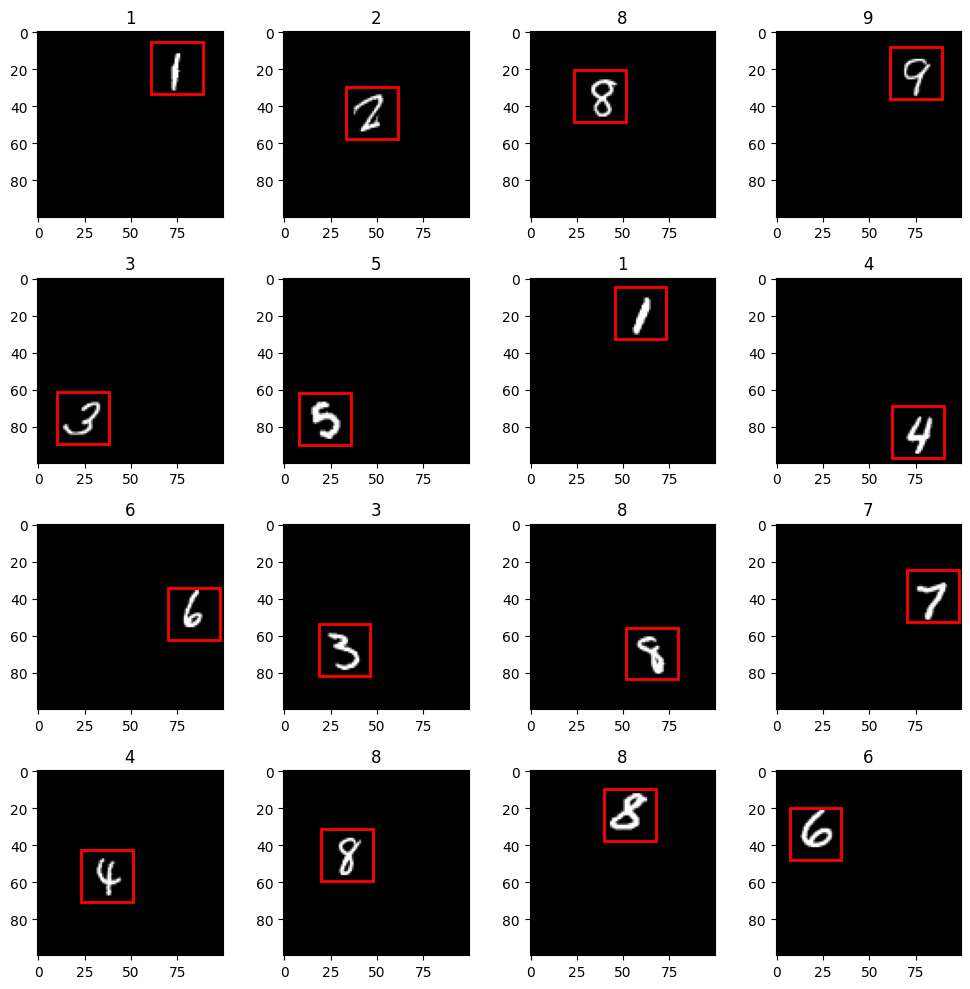

In [11]:
num_rows = 4
num_cols = 4

fig, axes = plt.subplots(num_rows, num_cols, figsize=(10, 10))

for i in range(num_rows):
    for j in range(num_cols):
        index = random.randint(0, 10000)
        image, cls, bb1 = train_dataset[index]
        print(image.size())
        bb = model1(image.unsqueeze(0).to(device))
        cls = model2(image.unsqueeze(0).to(device))

        # Plot the image
        axes[i, j].imshow(image.permute(1, 2, 0), cmap="gray")

        # Set the title as the predicted class
        num = torch.argmax(cls, dim = 1).item()
        axes[i, j].set_title(num)

        # Convert the bounding box predictions to numpy array and scale
        bb = bb.cpu().detach().numpy()
        bb1 = bb1 * 100
        bb = bb * 100

        # Get the x and y coordinates of the bounding box
        x, y = bb[0, 0], bb[0, 1]

        # Add a rectangle patch to the image
        rect = plt.Rectangle((x, y), 28, 28, linewidth=2, edgecolor='r', facecolor='none')
        axes[i, j].add_patch(rect)

# Adjust the spacing between subplots
plt.tight_layout()

# Show the plot
plt.show()


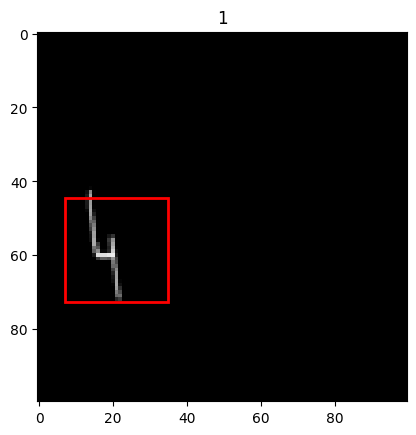

In [12]:
def process_image(image_path):
    image1 = Image.open(image_path)
    image = Image.open(image_path).convert('L')  # Convert to grayscale
    if image.mode in ('RGBA', 'LA'):  # Check if image has alpha channel
        image = image.convert(image.mode[:-1])  # Remove alpha channel
    image = image.resize((100, 100))  # Resize the image to 100x100
    image_np = np.array(image) # Convert to numpy array and normalize to [0,1]
    image_tensor = torch.from_numpy(image_np)  # Convert to PyTorch tensor
    return image_tensor.double(), image1

def final_model(image_path):
    input_image, original = process_image(image_path)

    # inputs = image_processor(input_image, return_tensors="pt")
    inputs = input_image.to(device).unsqueeze(0)

    bb = model1(inputs.unsqueeze(0).to(device))
    cls = model2(inputs.unsqueeze(0).to(device))

    num = torch.argmax(cls, dim = 1).item()

    bb = bb.cpu().detach().numpy()
    bb = bb * 100

    x, y = bb[0, 0], bb[0, 1]

    # Plotting
    plt.imshow(original.resize((100, 100)), cmap='gray')  # Display the image in grayscale
    rect = plt.Rectangle((x, y), 28, 28, linewidth=2, edgecolor='r', facecolor='none')  # Create a rectangle
    plt.gca().add_patch(rect)  # Add the rectangle to the plot

    plt.title(str(num))  # Set the title to the class number
    plt.show()

img_path = "/content/test.jpg"
final_model(img_path)

In [13]:
torch.save(model1.state_dict(), "/content/drive/MyDrive/bb.pth")
torch.save(model2.state_dict(), "/content/drive/MyDrive/cls.pth")